In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import altair as alt
import pandas as pd

c:\Users\bapti\projet_NLP\env_projet_NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df= pd.read_csv("../Data_csv/data_preprocessed.csv")[["Name of the document", "Institution", "text_processed", "theme"]]

In [3]:
# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !


df['tokenize'] = df['text_processed'].apply(lambda x: word_tokenize(x))

In [4]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    n_samples = len(texts)
    if voc == None:
        words = set()
        for text in texts:
            words = words.union(set(text)) # list of all words
        n_features = len(words) # number of different words
        vocabulary = dict(zip(words, range(n_features))) # vocab[wd] = index ; indexisation
    else:
        vocabulary = voc
        n_features = len(voc)
    counts = np.zeros((n_samples, n_features))
    for k, text in enumerate(texts): # enumeration a k for a text[k]
        for w in text:
            if w in vocabulary:
                counts[k][vocabulary[w]] += 1.
    return vocabulary, counts

In [5]:
voc, bow = count_words(df['tokenize'])
print(bow.shape)

(458, 212670)


In [64]:
# Create and fit the vectorizer to the training data
custom_stop_words = ['ai', 'data']
vectorizer = CountVectorizer(stop_words=custom_stop_words)
Bow = vectorizer.fit_transform(df['text_processed'])
bow_a = Bow.toarray()
voc_a = vectorizer.vocabulary_
print(bow_a.shape)

(458, 143808)


In [65]:
frequency = bow_a.sum(axis = 0)
top_words = np.argsort(frequency)[::-1]

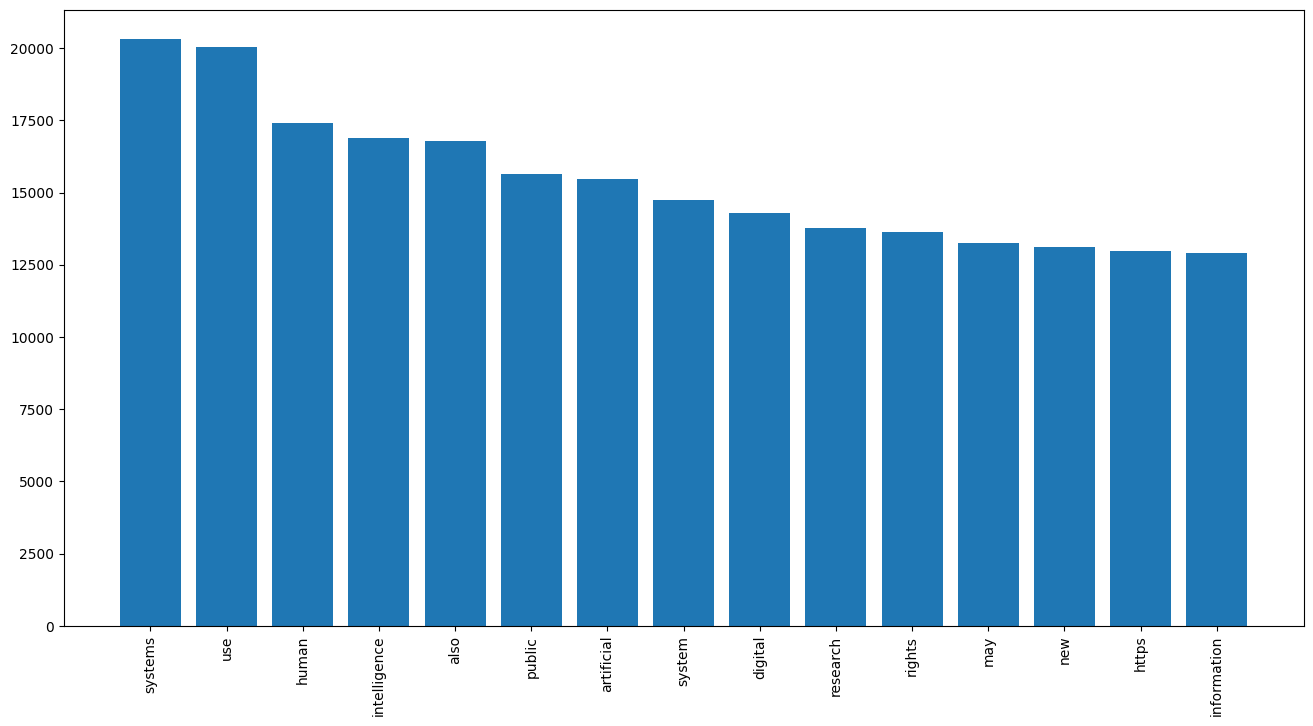

In [66]:
rev_voc = {i: w for w, i in voc_a.items()}
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(15), frequency[top_words[:15]])
ax.set_xticks(range(15))
ax.set_xticklabels([rev_voc[i] for i in top_words[:15]], rotation='vertical')
plt.show()

In [20]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))



In [21]:


def tfidf_transform(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    """
    # IDF
    d = float(bow.shape[0]) + 1.0
    in_doc = bow.astype(bool).sum(axis=0) + 1.0
    idfs = np.log(d / in_doc) + 1.0
    # TF
    sum_vec = bow.sum(axis=1)
    tfs = bow / np.expand_dims(sum_vec + 1.0, axis=1)
    tf_idf = tfs * np.expand_dims(idfs,axis=0)
    return tf_idf

In [67]:
tfidf = tfidf_transform(bow_a)
print(tfidf.shape)

(458, 143808)


In [24]:
# Create and fit the vectorizer to the training data
tfidf_vectorizer = TfidfVectorizer()
Tfidf = tfidf_vectorizer.fit_transform(df['text_processed'])
tfidf_a = Tfidf.toarray()
print(tfidf_a.shape)

(458, 143810)


In [25]:
pca = PCA(n_components=2, whiten=True)
docs_pca = pca.fit_transform(tfidf)

In [26]:
data = pd.DataFrame({'x': docs_pca[:,0],
                     'y': docs_pca[:,1],
                     'theme': df['theme']})
                     #'Category': categories_l})

In [27]:
alt.Chart(data[:]).mark_circle(size=200).encode(
    x="x", y="y",# color='Category',
    tooltip=['theme']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

### III - 2 With T-SNE

From the ```sklearn``` documentation: 
- t-SNE [1] is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. **with different initializations we can get different results**.
- In particular, t-SNE has the advantage to reveal data that lie in multiple, different, manifolds or clusters.
- It is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples.

From this recommendation, we will initialize ```TSNE``` with PCA (choosing the argument ```init='pca'``` when creating the class).

In [28]:
docs_tsne = TSNE(n_components=2, learning_rate='auto',
                  init='pca').fit_transform(tfidf)
print(docs_tsne.shape)

(458, 2)


In [29]:
data_th = pd.DataFrame({'x': docs_tsne[:,0],
                     'y': docs_tsne[:,1],
                     'theme': df['theme']})
                     #'Category': categories_l})

In [30]:
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", 
    y="y", 
    color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme']
).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

<div class='alert alert-block alert-warning'>
            Question:</div>
                        
- Is there any conclusion we can draw with respect to the lexical features and how they allow us to group the documents in this dataset ? 

### III - 3 Topic modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension before visualization. 

The underlying idea is to **take advantage of the latent structure in the association between the set of
words and the set of documents**. Many methods have been designed to do this - the earliest being **topic models**. 

Note that this allows to obtain reduced document representations, in a **topic space, common to documents and words** - where each document is described as a vector of topics and for each topic, we have access to the importance of words. 


We will do this with two models:
- Using the ```TruncatedSVD```, we will **linearly** reduce the dimension of our BOW representations. This is called *Latent Semantic Analysis* (LSA). 
- Using a *generative model* based on several assumptions on how a document is generated through topics, which the model will retrieve: this is ```LatentDirichletAllocation``` (LDA).

We use here another dataset from this [paper](https://aclanthology.org/2024.latechclfl-1.28/) which includes quite more categories and will be more interesting to explore, as we can expect it to contain clusters clearly visible through looking at lexical features. You can find the dataset on their [git repository](https://git.unistra.fr/thealtres/stage-direction-classif-french-transfer-learning).

First, apply the same pipeline than before:
- Does the data need to be cleaned and pre-processed ?
- Obtain BOW and TF-IDF representations.
- Visualize them with T-SNE.

<div class='alert alert-block alert-info'>
            Code:</div>

In [31]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                    init='pca').fit_transform(tfidf)
data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        'theme': df['theme']})
                        #'Category': df['labelGeneric']
alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", 
    y="y", 
    color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme']
).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

**Latent Semantic Analysis**: let us choose an arbitrary number of topics - which will be the size of the joint *topic space*.

In [42]:
n_topics = 5
lsa = TruncatedSVD(n_components = n_topics)
lsa_topics = lsa.fit_transform(tfidf)

In [43]:
# Correspondances between documents and topics
print(lsa_topics.shape)
# Correspondances between topics and words
print(lsa.components_.shape)

(458, 5)
(5, 143810)


In [44]:
# Reversing the vocabulary to retrieve words from indexes, allowing to find the most important words for each topic
rev_voc_th = {i: w for w, i in voc_a.items()}

In [45]:
def most_important_words(n, reverse_vocabulary, topic_model):
    out = []
    for i, topic in enumerate(topic_model.components_):
        out.append([reverse_vocabulary[j] for j in topic.argsort()[:-n-1:-1]])
    return out

In [46]:
words = most_important_words(4, rev_voc_th, lsa)
for i, topic in enumerate(words[:15]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['redirect', 'ai', 'data', 'learning']
Topic  2  :  ['mec', 'wrap', 'colorskin', 'booking']
Topic  3  :  ['height', '100', 'margin', 'html']
Topic  4  :  ['ai', 'javascript', 'data', 'osf']
Topic  5  :  ['javascript', 'osf', 'ethical_colombia', 'browser']


In [47]:
# Pour chaque document, trouvez l'index du topic dominant
dominant_topics_lsa = lsa_topics.argmax(axis=1)

With a dataset this size, over **short texts**, it is difficult to interpret the topics (many short words, even with TF-IDF). Let's apply T-SNE ! 

In [48]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                  init='pca', metric='cosine', perplexity=50.0).fit_transform(lsa_topics)
print(docs_tsne_th.shape)

data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        #'theme': df['theme']})
                        'theme': dominant_topics_lsa })

alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", 
    y="y", 
    color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme']
).interactive().properties(
    width=500,
    height=500
)


(458, 2)


alt.Chart(...)

**Latent Dirichlet Allocation**: 

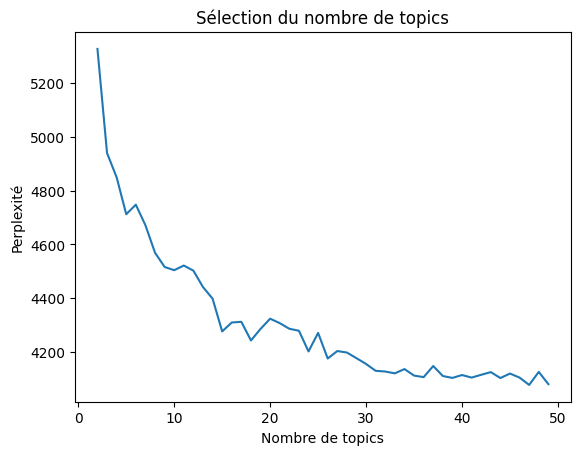

In [73]:
perplexities = []
for k in range(2, 50):  # Tester différents nombres de topics
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(bow_a)  # bow est votre matrice de document-terme
    perplexities.append(lda_model.perplexity(bow_a))

# Tracer la perplexité
plt.plot(range(2, 50), perplexities)
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité")
plt.title("Sélection du nombre de topics")
plt.show()



nombre de topics intéressants: 5, 10, 15

In [78]:
n_topics = 10
lda = LatentDirichletAllocation(n_components = n_topics)
lda_topics_th = lda.fit_transform(bow_a)

In [82]:
words = most_important_words(10, rev_voc_th, lda)
for i, topic in enumerate(words[:11]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['digitaalhulpplein', 'researc', 'developme', 'publ', 'intelligen', 'governme', 'nevralt_nettverk', 'nation', 'artificiai', 'strategist']
Topic  2  :  ['systeem', 'usdaw', 'mode', 'maxqda', 'decisifs', 'informatik', 'healsowasresponsibleformacquarie', 'systemlevel', 'risinājumu', 'proceso']
Topic  3  :  ['humains', 'systemlevel', 'rightparties', 'http', 'ethicomp98', 'usdaw', 'maxqda', '2018', 'intelligen', 'alskills']
Topic  4  :  ['rightparties', 'systemlevel', 'usdaw', 'protecting_the_internet_as_common_heritage_of_mankind', 'etzione', 'lavoué', 'europeacknowledgements', 'systeem', 'alskills', 'legacies']
Topic  5  :  ['wrap', 'secting', 'widow', 'carclubs', 'contenidos', 'margetts', 'mavige', 'medhurst', 'fonográficos', 'toovercomesuchdynamics']
Topic  6  :  ['akçay', 'tinyurl', 'ethicomp98', 'tréal', 'ecycle', 'wgood', 'eröffnet', 'atio', 'pproved', 'alskills']
Topic  7  :  ['algorithmnumber', 'intelligen', 'artificiai', 'enforceme', 'faci', 'ethic', 'lavoué', 'recogn

In [80]:
# Pour chaque document, trouvez l'index du topic dominant
dominant_topics = lda_topics_th.argmax(axis=1)



In [81]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                  init='pca', metric='cosine', perplexity=50.0).fit_transform(lda_topics_th)
print(docs_tsne_th.shape)

data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        #'theme': df['theme']})
                        'theme': dominant_topics })

alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", 
    y="y", 
    color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme']
).interactive().properties(
    width=500,
    height=500
)

(458, 2)


alt.Chart(...)

<div class='alert alert-block alert-warning'>
            Further question:</div>
  
- Are there any other features that we could consider with the same tools (Second dataset) ?

<div class='alert alert-block alert-info'>
            Code:</div>
            
- Apply the pipeline to obtain a t-sne visualisation over these proposed features. Did it work as expected ? 

### III - 4 Take away

**Idea**: the key to improving representations is to embed data capturing text statistics in a compact space.

But how ? 
Let's look at how a compact **modern (deep learning based) model** can better capture what's happening in our dataset:

In [38]:
%%capture output



tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base")
model.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# This code is very inefficient: it will take documents one by one and make them go through the model
# We can usually process several of them together to gain time: this is called batching
# Batching may require a large quantity of memory, and to avoid any issue when running this locally,
# we will keep this (very slow and) inefficient solution. 
vectors = []
for i, example in enumerate(df['text_processed'].tolist()):
    inputs = tokenizer(example, truncation=True, padding=True, return_tensors="pt")
    outputs = model(**inputs)
    vectors.append(outputs.last_hidden_state[0,0,:].detach().numpy()[np.newaxis, :])

In [40]:
# The model outputs vectors of size 768
cam_rep = np.concatenate(vectors, axis=0)
print(cam_rep.shape)

(508, 768)


In [41]:


kmeans = KMeans(n_clusters=10, random_state=0)


kmeans.fit(cam_rep)


labels = kmeans.labels_


print(labels)

[8 7 9 8 6 8 7 7 7 8 7 3 8 7 5 5 5 4 5 3 8 0 7 8 7 5 9 8 7 5 5 5 7 0 5 8 8
 7 9 8 8 9 8 5 6 8 8 7 5 6 0 8 3 7 6 6 4 4 2 2 7 3 3 8 3 5 7 5 7 7 0 8 7 8
 2 7 3 3 7 5 3 0 0 3 3 3 8 1 5 5 5 7 5 7 5 7 0 7 0 0 3 0 3 0 3 3 0 0 7 8 7
 7 7 3 3 7 7 8 7 8 0 7 8 6 8 2 2 2 2 2 2 2 8 2 2 9 8 8 8 7 5 1 4 8 3 9 0 1
 7 3 7 1 3 7 1 4 7 8 3 1 3 4 4 3 3 3 3 3 3 3 4 3 6 3 5 7 7 9 3 3 3 3 3 3 3
 7 3 3 3 3 3 3 7 3 3 3 1 3 3 3 3 3 7 3 3 3 4 7 3 3 0 1 0 3 3 8 3 3 7 3 0 8
 7 2 7 5 7 5 6 8 0 7 7 8 7 7 3 5 3 5 8 8 7 1 7 3 4 7 7 7 4 8 8 3 2 3 7 6 7
 2 2 8 7 5 8 5 8 8 4 4 5 8 8 8 4 2 0 0 2 5 7 7 8 7 8 5 7 8 7 6 8 6 8 3 8 3
 5 9 5 7 5 7 8 8 3 9 6 8 9 3 8 9 8 8 9 9 7 8 7 7 5 0 9 7 5 7 7 3 7 3 3 8 8
 8 0 3 5 7 8 7 7 0 9 0 8 6 8 9 4 3 3 3 3 1 3 3 3 3 4 1 9 3 5 1 1 3 7 9 1 9
 1 6 8 8 0 7 8 9 3 3 2 8 9 7 9 9 8 4 8 8 8 7 7 5 9 9 6 5 8 8 6 5 6 5 5 8 8
 5 3 5 1 5 7 7 7 5 7 0 7 8 7 3 8 7 7 3 7 7 8 7 8 8 7 8 7 7 0 8 7 3 3 5 5 3
 0 5 6 2 2 2 2 3 2 2 8 7 2 7 3 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 8 8 8 8 8 8
 3 8 7 5 5 3 8 8 8 8 6 5 

In [42]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                    init='random', metric='cosine',
                    perplexity=50.0).fit_transform(cam_rep)
print(docs_tsne_th.shape)

data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        'theme': df['theme'],
                        'title': df["Name of the document"],
                        'labels': labels
                        })

alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", y="y", color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme', "title"]
    ).interactive().properties(
    width=500,
    height=500
)

(508, 2)


alt.Chart(...)

We will see how such a model (*CamemBERT*) works (relatively) soon ! 